# Evironment initialization

In [1]:
source("./initialization.r")

Loading required package: ggplot2
Loading required package: dplyr

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: DT
Loading required package: GGally
Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Attaching package: ‘GGally’

The following object is masked from ‘package:dplyr’:

    nasa

Loading required package: magick
Linking to ImageMagick 6.9.9.39
Enabled features: cairo, fontconfig, freetype, lcms, pango, rsvg, webp
Disabled features: fftw, ghostscript, x11
Loading required package: cowplot

********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************

Loading re

# Data inspection

In [2]:
bugsData <- read.table("bugs.csv", header=TRUE, sep=";", stringsAsFactors=FALSE)

In [3]:
classes <- sapply(bugsData, class)
classes
dim(bugsData)
dim(na.omit(bugsData))

CBO                 DIT               FanIn              FanOut 
          "integer"           "integer"           "integer"           "integer" 
               LCOM                 NOC                 RFC                 WMC 
          "integer"           "integer"           "integer"           "integer" 
                LOC          Attributes AttributesInherited             Methods 
          "integer"           "integer"           "integer"           "integer" 
   MethodsInherited                Bugs 
          "integer"           "integer"

[1] 997  14

[1] 997  14

In [4]:
summary(bugsData)

      CBO              DIT            FanIn             FanOut      
 Min.   :  0.00   Min.   :1.000   Min.   :  0.000   Min.   : 0.000  
 1st Qu.:  3.00   1st Qu.:1.000   1st Qu.:  1.000   1st Qu.: 2.000  
 Median :  7.00   Median :2.000   Median :  2.000   Median : 4.000  
 Mean   : 12.22   Mean   :2.727   Mean   :  5.368   Mean   : 7.395  
 3rd Qu.: 14.00   3rd Qu.:4.000   3rd Qu.:  4.000   3rd Qu.:10.000  
 Max.   :156.00   Max.   :8.000   Max.   :137.000   Max.   :93.000  
      LCOM              NOC               RFC               WMC         
 Min.   :    0.0   Min.   : 0.0000   Min.   :   0.00   Min.   :   0.00  
 1st Qu.:    6.0   1st Qu.: 0.0000   1st Qu.:  12.00   1st Qu.:   8.00  
 Median :   28.0   Median : 0.0000   Median :  30.00   Median :  20.00  
 Mean   :  364.7   Mean   : 0.7121   Mean   :  76.87   Mean   :  58.38  
 3rd Qu.:   91.0   3rd Qu.: 0.0000   3rd Qu.:  70.00   3rd Qu.:  50.00  
 Max.   :81003.0   Max.   :26.0000   Max.   :2603.00   Max.   :1680.00  
      

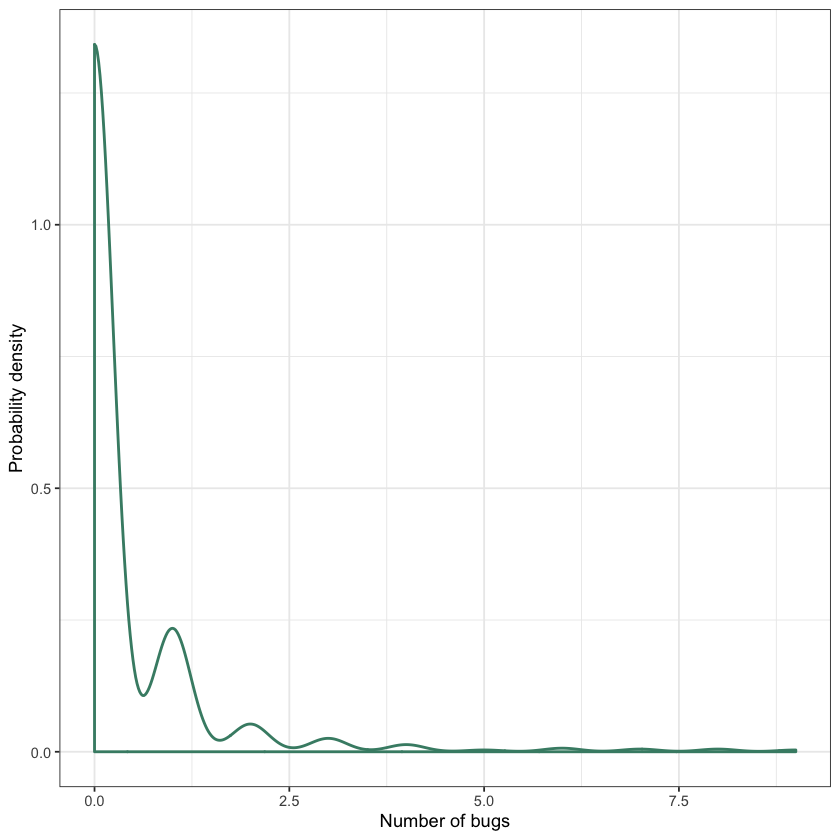

In [5]:
 ggplot(data=bugsData, aes(x=Bugs)) +
  geom_density(color = "aquamarine4", lwd = 0.8) +
  labs(x = "Number of bugs", y = "Probability density") +
  theme_bw()

# Statistical analysis
Correletion "matrix"

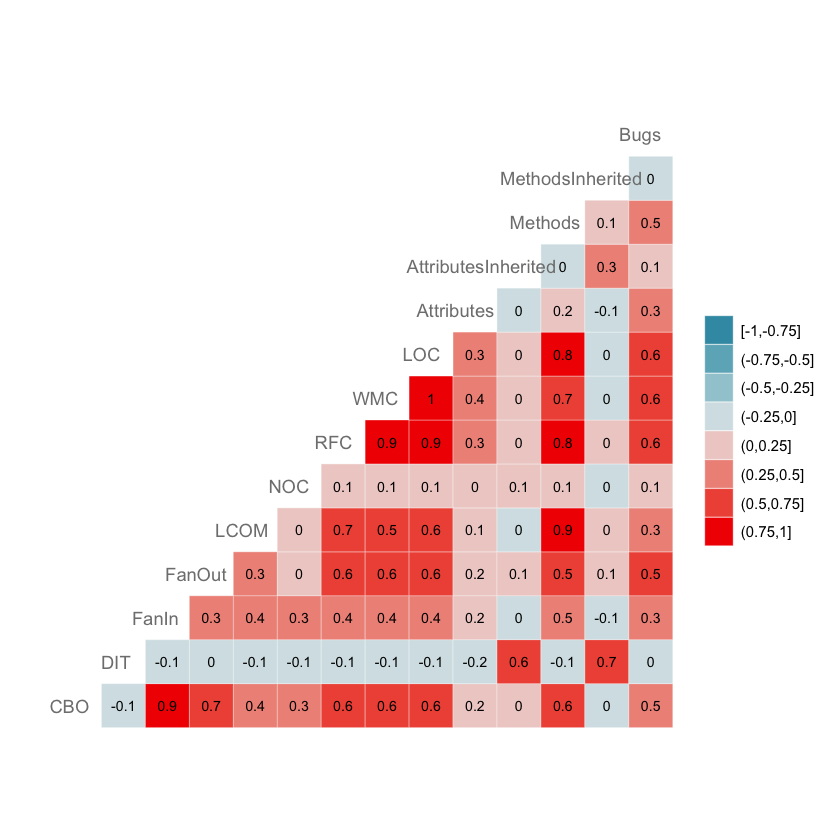

In [6]:
ggcorr(
    bugsData,
    nbreaks = 8,
    label = TRUE,
    label_size = 3,
    color = "grey50",
    layout.exp = 1,
    hjust = 0.75,
    method=c("pairwise", "pearson")
)

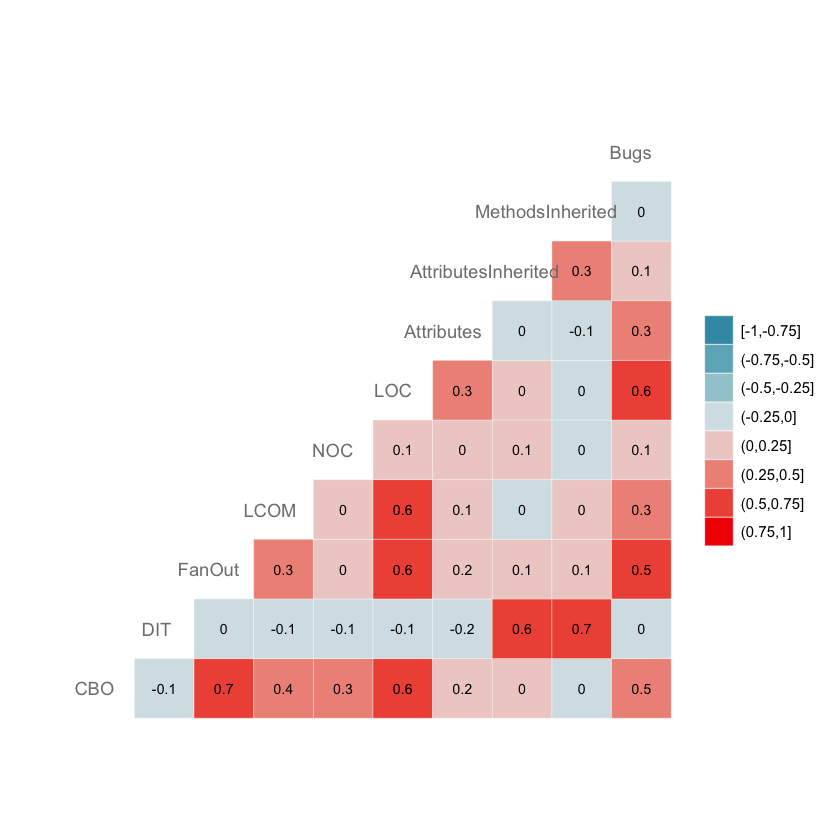

In [7]:
bugsDataWoCor <- subset(bugsData, select = -c(Methods, FanIn, WMC, RFC))
ggcorr(
    bugsDataWoCor,
    nbreaks = 8,
    label = TRUE,
    label_size = 3,
    color = "grey50",
    layout.exp = 1,
    hjust = 0.75,
    method=c("pairwise", "pearson")
)

## Data distribution plotted
Don't know how to interpret this...

In [8]:
numericChart <- function(colName, colorCol) {
  ggplot(bugsData, aes(x = Bugs, y = bugsDataWoCor[[colName]])) +
    geom_jitter(size = 1.5, stat = "identity", colour=colorCol) +
    labs(x = "Bugs", y = colName) +
    theme_bw()
}

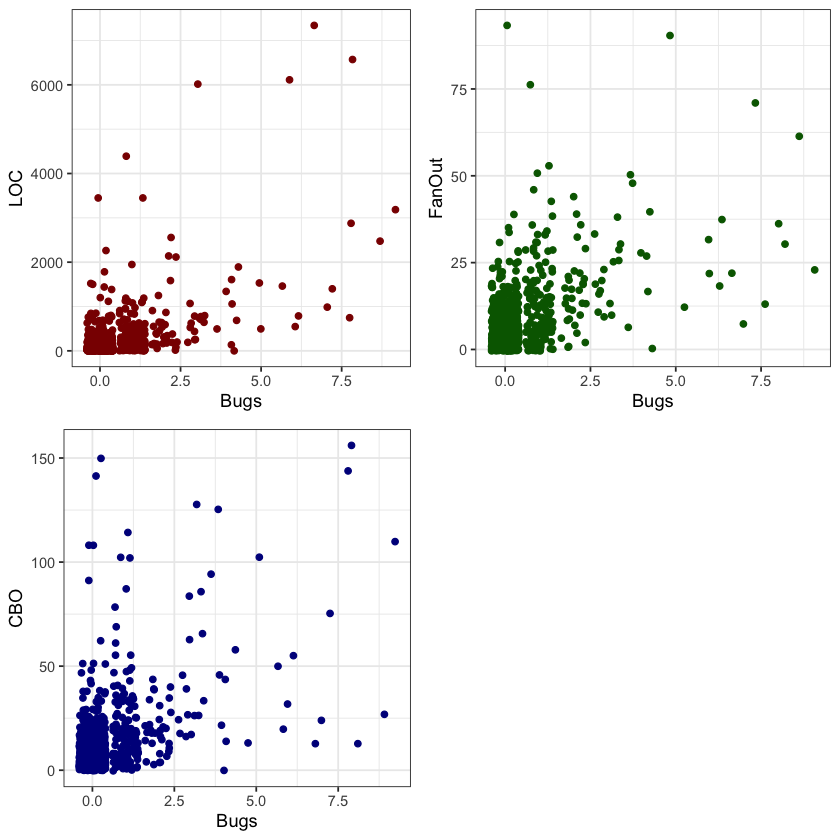

In [9]:
plot_grid(
  numericChart("LOC", "darkred"),
    numericChart("FanOut", "darkgreen"),
    numericChart("CBO", "darkblue")
)

# Prepare prediction environment

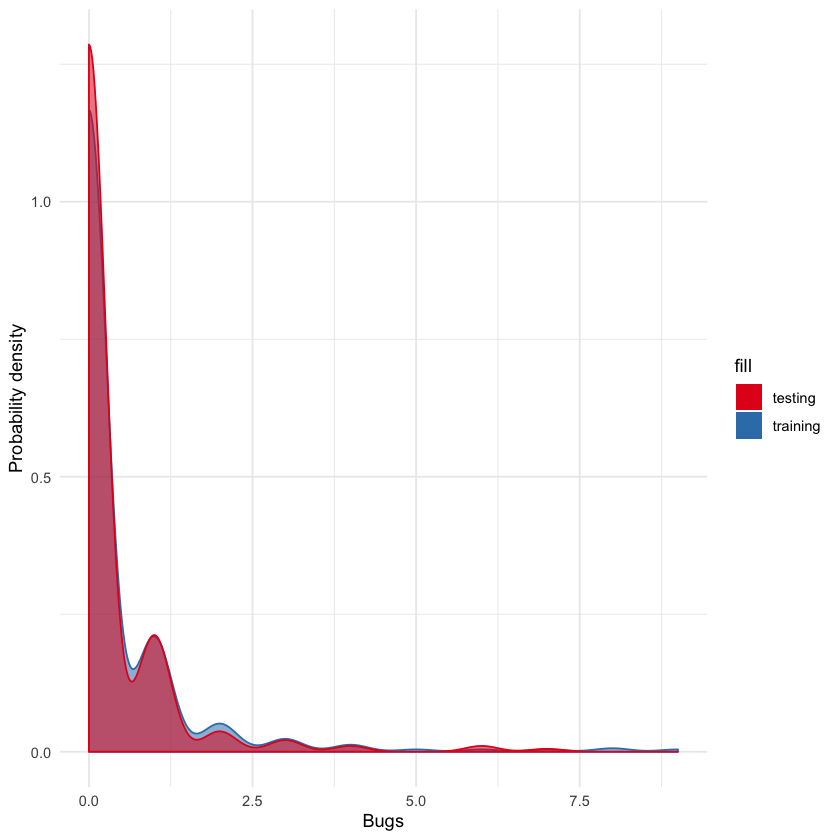

In [10]:
inTrain <- createDataPartition(bugsDataWoCor$Bugs, p=0.7, list=FALSE)
training <- bugsDataWoCor[inTrain,]
testing <- bugsDataWoCor[-inTrain,]

ggplot(mapping=aes(alpha=0.2)) + 
 geom_density(aes(Bugs, fill="training", color="training"), training) + 
 geom_density(aes(Bugs, fill="testing", color="testing"), testing) + 
 theme_minimal() +
  xlab("Bugs") +
  ylab("Probability density") +
  scale_fill_brewer(palette="Set1") +
  scale_color_brewer(palette="Set1") + 
  guides(color = FALSE, alpha = FALSE, fill=guide_legend(override.aes = list(color = NA)))

In [11]:
X_train = select(training, -Bugs)
y_train = training$Bugs
X_test = select(testing, -Bugs)
y_test = testing$Bugs

In [12]:
trcontrol = trainControl(
  method = "cv",
  number = 10,  
  allowParallel = TRUE,
  verboseIter = FALSE,
  returnData = FALSE
)

In [13]:
evaluateStats <- function(model) {
  predicted = predict(model, X_test)
  residuals = y_test - predicted
  
  RMSE <- round(sqrt(mean(residuals^2)), 3)
  
  y_testMean = mean(y_test)
  totalSS =  sum((y_test - y_testMean)^2 )
  residualSS =  sum(residuals^2)
  rSquare  =  round(1 - (residualSS/totalSS), 3)
  
  list(RMSE = RMSE, rSquare = rSquare)
}

In [14]:
predictionChart <- function(model) {
  predicted = predict(model, X_test)
  mergedResults = as.data.frame(cbind(predicted = predicted, observed = y_test))
  # Plot predictions vs test data
  ggplot(mergedResults, aes(y = predicted, x = observed)) +
    geom_point(color = "darkred", alpha = 0.5) + 
    geom_smooth(method=lm) +
    ylab("Predicted number of bugs") +
    xlab("Real number of bugs") + 
    theme(
      axis.text.y = element_text(size=12), axis.text.x = element_text(size=12,hjust=.5),
      axis.title.x = element_text(size=14), axis.title.y = element_text(size=14)
    )
}

In [15]:
importancePlot <- function(model) ggplot(varImp(model))

# kNN without Preprocessing

In [16]:
knnGrid <- expand.grid(k = seq(1, 25, by = 2))

In [17]:
knnModel <- train(
  X_train, y_train,
  method = "knn",
  trControl = trcontrol,
  tuneGrid = knnGrid
)

In [18]:
knnModel

k-Nearest Neighbors 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 628, 628, 629, 629, 628, 628, ... 
Resampling results across tuning parameters:

  k   RMSE       Rsquared   MAE      
   1  0.9738604  0.3166571  0.4089337
   3  0.9141726  0.3215709  0.4010542
   5  0.8885906  0.3788906  0.4018440
   7  0.8869073  0.3692163  0.4094269
   9  0.8762427  0.3781831  0.4085295
  11  0.8697174  0.3821802  0.4073308
  13  0.8608442  0.3961715  0.4050139
  15  0.8645772  0.3928235  0.4056318
  17  0.8668222  0.3905188  0.4054723
  19  0.8631789  0.3946609  0.4051216
  21  0.8557129  0.4100743  0.4012737
  23  0.8642889  0.4007043  0.4043700
  25  0.8679186  0.3985742  0.4041519

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was k = 21.

In [19]:
knnModel$bestTune
knnStats <- evaluateStats(knnModel)
knnStats

,k
,<dbl>
11,21


$RMSE
[1] 0.728

$rSquare
[1] 0.306

##### knnStats <- evaluateStats(knnModel)
knnStats

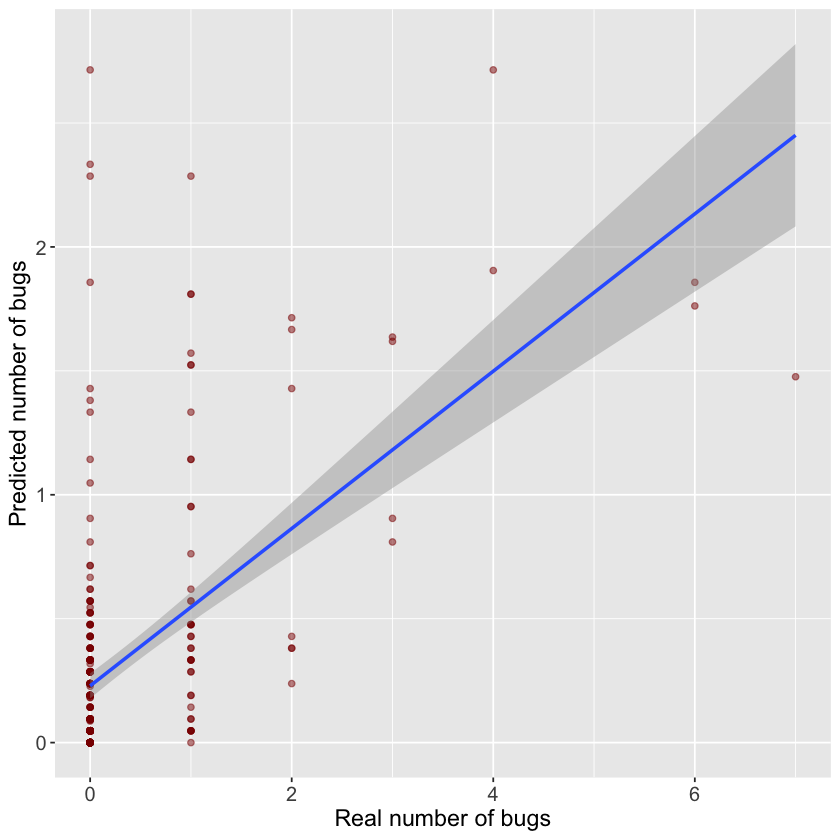

In [20]:
predictionChart(knnModel)

# kNN with Preprocessing

In [21]:
knnPreModel <- train(
  X_train, y_train,
  method = "knn",
  trControl = trcontrol,
  tuneGrid = knnGrid,
  preProcess = c("center", "scale")
)

In [22]:
knnPreModel

k-Nearest Neighbors 

Pre-processing: centered (9), scaled (9) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 628, 628, 628, 628, 628, 628, ... 
Resampling results across tuning parameters:

  k   RMSE       Rsquared   MAE      
   1  1.0596593  0.3096372  0.4112008
   3  0.9425811  0.2929635  0.3920618
   5  0.9274121  0.3139379  0.3979503
   7  0.9012318  0.3342301  0.4002418
   9  0.8733496  0.3557081  0.3987219
  11  0.8721816  0.3645884  0.4015636
  13  0.8795089  0.3630878  0.4049179
  15  0.8742228  0.3742824  0.4047379
  17  0.8821147  0.3675678  0.4071276
  19  0.8845338  0.3685908  0.4067247
  21  0.8899290  0.3652745  0.4085865
  23  0.8971203  0.3586556  0.4100980
  25  0.9019072  0.3561730  0.4108228

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was k = 11.

In [23]:
knnPreModel$bestTune

,k
,<dbl>
6,11


In [24]:
knnPreStats <- evaluateStats(knnPreModel)
knnPreStats

$RMSE
[1] 0.752

$rSquare
[1] 0.258

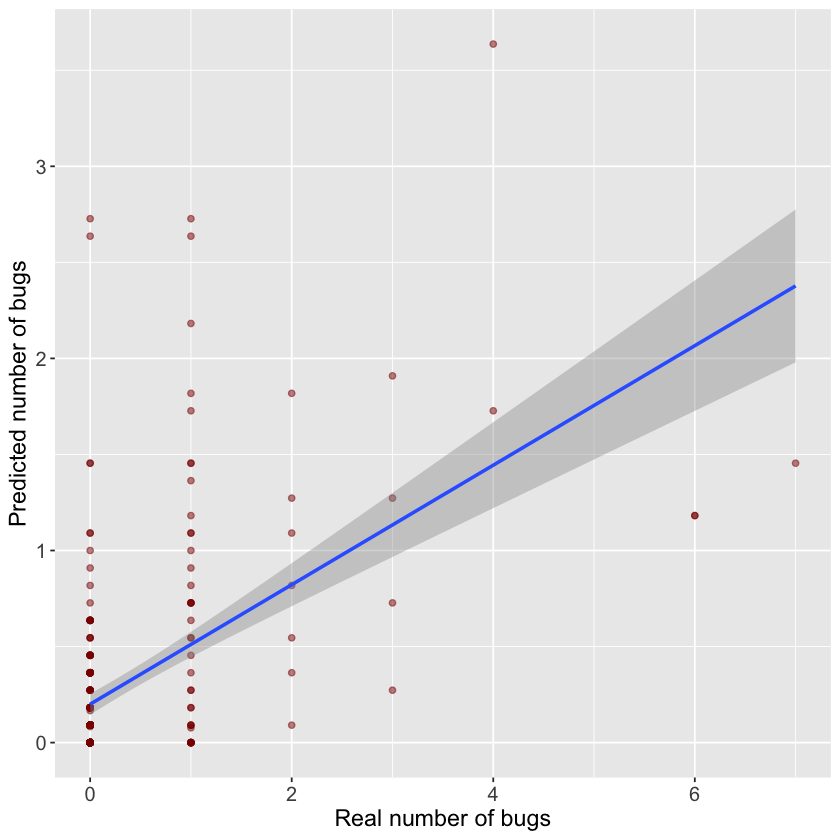

In [25]:
predictionChart(knnPreModel)

# Random Forest Regression

In [26]:
rfGrid <- expand.grid(.mtry=ncol(X_train)/3)

In [27]:
rfModel <- train(
  X_train, y_train,
  method = "rf",
  trControl = trcontrol,
  tuneGrid = rfGrid,
  importance = TRUE
)

In [28]:
rfModel

Random Forest 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 628, 629, 628, 629, 628, 628, ... 
Resampling results:

  RMSE       Rsquared   MAE      
  0.8698677  0.4075966  0.4251463

Tuning parameter 'mtry' was held constant at a value of 3

In [29]:
rfModel$bestTune

mtry
<dbl>
3


In [30]:
rfStats <- evaluateStats(rfModel)
rfStats

$RMSE
[1] 0.742

$rSquare
[1] 0.277

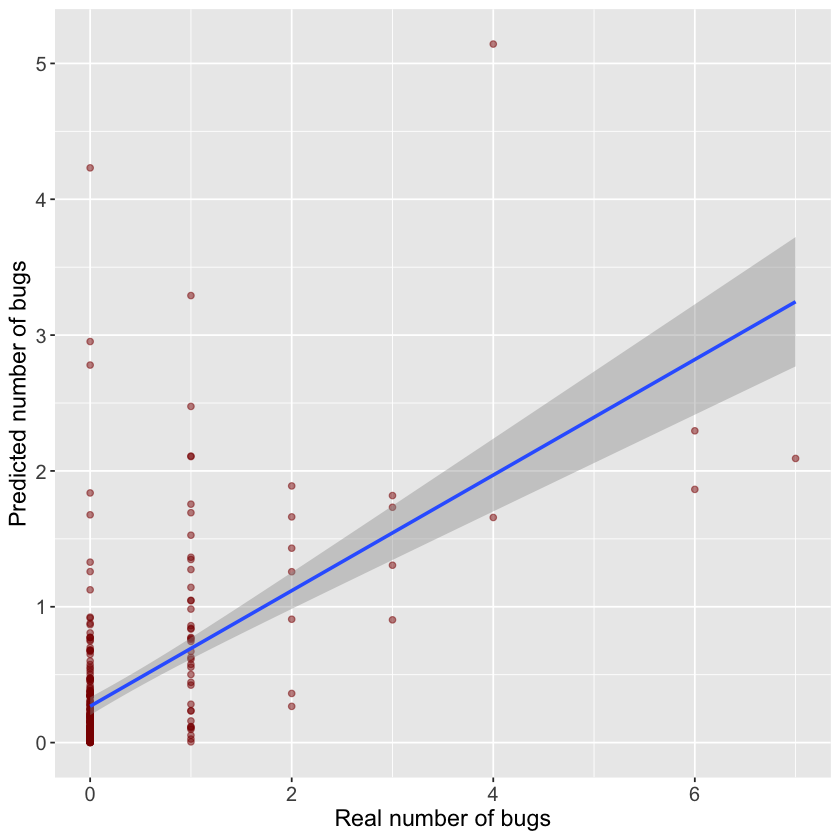

In [31]:
predictionChart(rfModel)

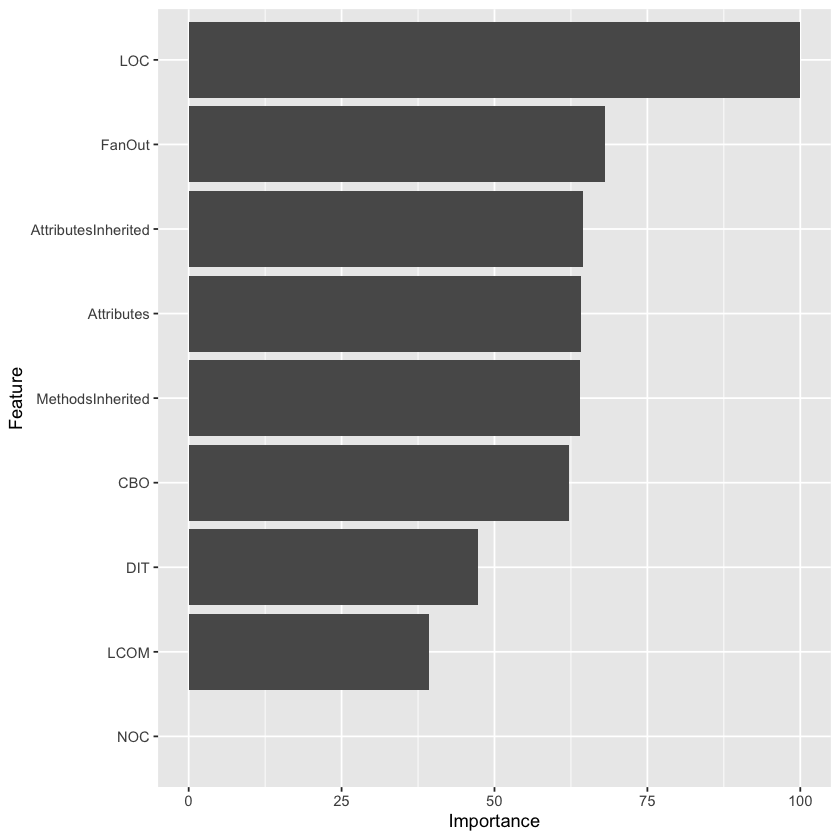

In [32]:
importancePlot(rfModel)

# Extreme Gradient Boosting regression

In [33]:
xgbGrid <- expand.grid(
    nrounds = c(100,200), 
    max_depth = c(10, 15, 20, 25),
    colsample_bytree = seq(0.5, 0.9, length.out = 5),
    eta = 0.1,
    gamma=0,
    min_child_weight = 1,
    subsample = 1
  )

In [34]:
xgbModel <- train(
  X_train, y_train,
  trControl = trcontrol,
  tuneGrid = xgbGrid,
  method = "xgbTree"
)

In [35]:
xgbModel

eXtreme Gradient Boosting 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 628, 628, 629, 628, 628, 628, ... 
Resampling results across tuning parameters:

  max_depth  colsample_bytree  nrounds  RMSE       Rsquared   MAE      
  10         0.5               100      0.8520303  0.3760136  0.4212637
  10         0.5               200      0.8525302  0.3756670  0.4218454
  10         0.6               100      0.8673880  0.3677544  0.4194998
  10         0.6               200      0.8680244  0.3671080  0.4198558
  10         0.7               100      0.8857980  0.3465287  0.4180608
  10         0.7               200      0.8865020  0.3456935  0.4186206
  10         0.8               100      0.9187249  0.3306097  0.4261753
  10         0.8               200      0.9191328  0.3304542  0.4266582
  10         0.9               100      0.9602491  0.2976374  0.4343018
  10         0.9               200      0.9607005  0.2973230  0.4346046
  15         0.5 

In [36]:
xgbModel$bestTune

nrounds,max_depth,eta,gamma,colsample_bytree,min_child_weight,subsample
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
100,10,0.1,0,0.5,1,1


In [37]:
xgbStats <- evaluateStats(xgbModel)
xgbStats

$RMSE
[1] 0.77

$rSquare
[1] 0.222

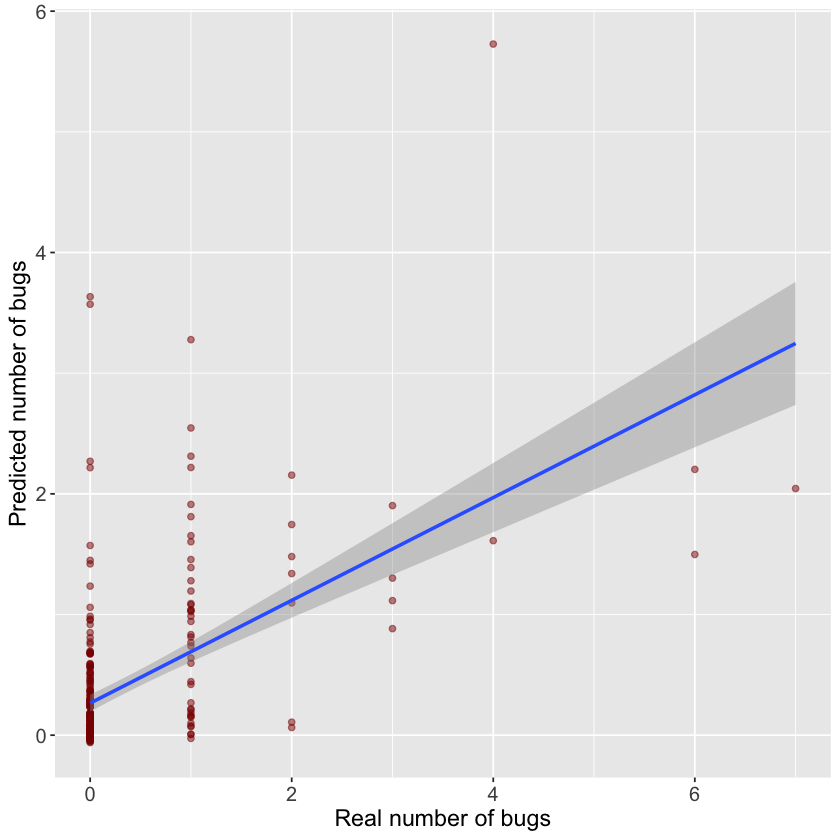

In [38]:
predictionChart(xgbModel)

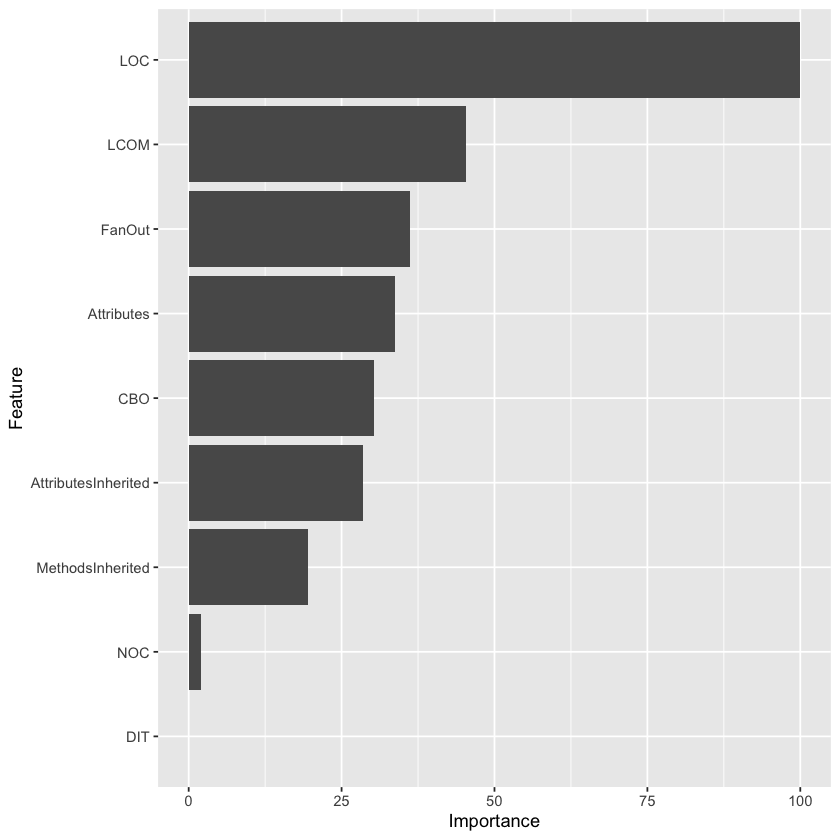

In [39]:
importancePlot(xgbModel)

## Xtreme Gradient Boosting with Preprocessing

In [40]:
xgbPreModel <- train(
  X_train, y_train,
  trControl = trcontrol,
  tuneGrid = xgbGrid,
  method = "xgbTree",
  preProcess = c("center", "scale")
)

In [41]:
xgbPreModel

eXtreme Gradient Boosting 

Pre-processing: centered (9), scaled (9) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 628, 628, 628, 628, 628, 628, ... 
Resampling results across tuning parameters:

  max_depth  colsample_bytree  nrounds  RMSE       Rsquared   MAE      
  10         0.5               100      0.8635218  0.3816990  0.4213014
  10         0.5               200      0.8638368  0.3815115  0.4217472
  10         0.6               100      0.8943739  0.3466102  0.4164193
  10         0.6               200      0.8949848  0.3462283  0.4169185
  10         0.7               100      0.8903941  0.3411536  0.4104056
  10         0.7               200      0.8910052  0.3407952  0.4112760
  10         0.8               100      0.8993021  0.3498131  0.4005771
  10         0.8               200      0.8998567  0.3495378  0.4013092
  10         0.9               100      0.9242171  0.3246356  0.4049068
  10         0.9               200      0.9247540  0.3245940  0.4

In [42]:
xgbPreModel$bestTune

nrounds,max_depth,eta,gamma,colsample_bytree,min_child_weight,subsample
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
100,10,0.1,0,0.5,1,1


In [43]:
xgbPreStats <- evaluateStats(xgbPreModel)
xgbPreStats

$RMSE
[1] 0.791

$rSquare
[1] 0.179

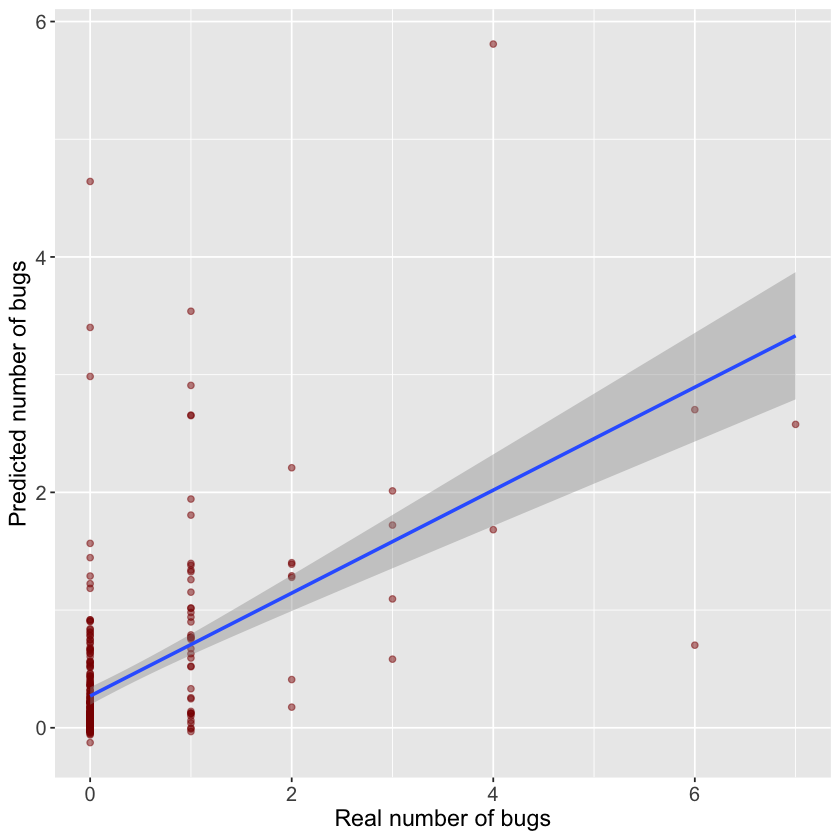

In [44]:
predictionChart(xgbPreModel)

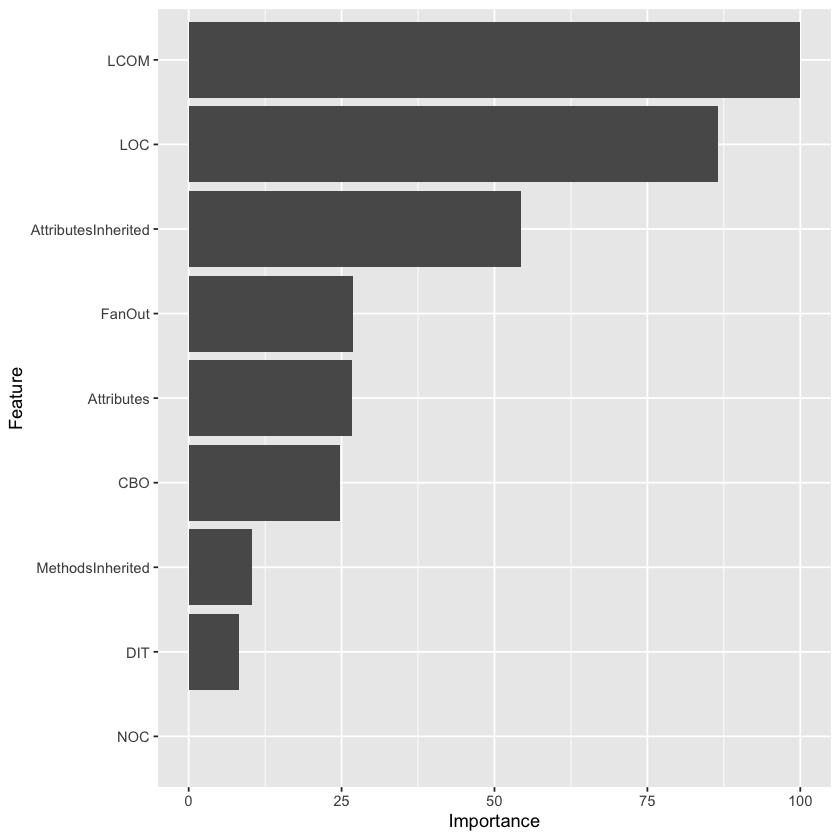

In [45]:
importancePlot(xgbPreModel)

# ANN redition using Caret library

In [46]:
nnetGrid <-  expand.grid(size = seq(from = 1, to = 10, by = 1),
                        decay = seq(from = 0.1, to = 0.5, by = 0.1))

In [47]:
nnetModel <- train(
  X_train, y_train,
  trControl = trcontrol,
  tuneGrid= nnetGrid,
  method = "nnet",
  preProcess = c("center", "scale")
)

# weights:  12
initial  value 797.259467 
iter  10 value 662.640346
iter  20 value 641.708758
iter  30 value 641.345990
final  value 641.326903 
converged
# weights:  23
initial  value 790.339541 
iter  10 value 679.480904
iter  20 value 646.248080
iter  30 value 633.048130
iter  40 value 627.021722
iter  50 value 626.324780
iter  60 value 626.321058
iter  70 value 626.205093
iter  80 value 626.008501
iter  90 value 625.901736
final  value 625.901712 
converged
# weights:  34
initial  value 866.826172 
iter  10 value 648.157529
iter  20 value 639.744060
iter  30 value 634.537706
iter  40 value 633.733030
iter  50 value 628.950067
iter  60 value 626.585232
iter  70 value 625.401199
iter  80 value 625.090992
iter  90 value 625.025133
final  value 625.023558 
converged
# weights:  45
initial  value 798.541452 
iter  10 value 646.374460
iter  20 value 638.561971
iter  30 value 634.924050
iter  40 value 633.693910
iter  50 value 631.713380
iter  60 value 626.076985
iter  70 value 624.419487

initial  value 926.763949 
iter  10 value 665.694440
iter  20 value 647.086371
iter  30 value 646.235386
iter  40 value 646.068231
iter  50 value 646.027722
iter  60 value 646.018155
iter  70 value 646.016606
final  value 646.016542 
converged
# weights:  111
initial  value 815.490190 
iter  10 value 679.294588
iter  20 value 646.607816
iter  30 value 646.049574
iter  40 value 645.922525
iter  50 value 645.776504
iter  60 value 645.682790
iter  70 value 645.061386
iter  80 value 643.802877
iter  90 value 643.544288
iter 100 value 643.451601
final  value 643.451601 
stopped after 100 iterations
# weights:  12
initial  value 792.368170 
iter  10 value 674.879978
iter  20 value 661.468922
final  value 661.422630 
converged
# weights:  23
initial  value 793.382879 
iter  10 value 664.374899
iter  20 value 655.500055
iter  30 value 655.095107
iter  40 value 655.093799
final  value 655.093786 
converged
# weights:  34
initial  value 774.926754 
iter  10 value 668.379900
iter  20 value 658.03

initial  value 712.521844 
iter  10 value 563.430445
iter  20 value 554.867368
iter  30 value 553.829401
iter  40 value 553.682461
final  value 553.678875 
converged
# weights:  45
initial  value 710.227627 
iter  10 value 564.776099
iter  20 value 556.427102
iter  30 value 555.006189
iter  40 value 554.858321
iter  50 value 554.848381
final  value 554.848370 
converged
# weights:  56
initial  value 727.855050 
iter  10 value 584.394388
iter  20 value 562.542464
iter  30 value 554.284034
iter  40 value 551.305064
iter  50 value 548.812191
iter  60 value 548.003308
iter  70 value 547.957581
iter  80 value 547.950940
iter  90 value 547.753676
iter 100 value 547.175543
final  value 547.175543 
stopped after 100 iterations
# weights:  67
initial  value 773.419086 
iter  10 value 579.998911
iter  20 value 555.022471
iter  30 value 553.536655
iter  40 value 549.530528
iter  50 value 548.458300
iter  60 value 547.977174
iter  70 value 547.808480
iter  80 value 547.762876
iter  90 value 547.74

initial  value 743.800457 
iter  10 value 570.480081
iter  20 value 565.320784
iter  30 value 564.159226
iter  40 value 563.905202
iter  50 value 563.864592
iter  60 value 563.863372
iter  60 value 563.863369
iter  60 value 563.863369
final  value 563.863369 
converged
# weights:  89
initial  value 727.079052 
iter  10 value 573.076360
iter  20 value 564.740671
iter  30 value 564.250524
iter  40 value 563.608566
iter  50 value 563.562871
iter  60 value 563.545311
final  value 563.544611 
converged
# weights:  100
initial  value 748.500545 
iter  10 value 573.700046
iter  20 value 564.030065
iter  30 value 563.462724
iter  40 value 563.403923
iter  50 value 563.375189
iter  60 value 563.374335
final  value 563.374323 
converged
# weights:  111
initial  value 768.045224 
iter  10 value 566.640924
iter  20 value 563.562744
iter  30 value 563.290762
iter  40 value 563.231673
iter  50 value 563.216630
final  value 563.216460 
converged
# weights:  12
initial  value 787.272168 
iter  10 valu

initial  value 807.167320 
iter  10 value 666.724457
iter  20 value 642.141897
iter  30 value 640.130694
iter  40 value 639.789305
iter  50 value 639.638278
iter  60 value 639.602809
iter  70 value 639.565426
iter  80 value 639.564083
final  value 639.564071 
converged
# weights:  89
initial  value 781.034973 
iter  10 value 645.630037
iter  20 value 642.623101
iter  30 value 641.832586
iter  40 value 641.489145
iter  50 value 641.243427
iter  60 value 641.182577
iter  70 value 641.166830
iter  80 value 641.165351
final  value 641.165308 
converged
# weights:  100
initial  value 828.249305 
iter  10 value 673.759932
iter  20 value 641.405960
iter  30 value 639.893163
iter  40 value 639.694018
iter  50 value 639.548949
iter  60 value 639.508344
iter  70 value 639.497157
iter  80 value 639.339508
iter  90 value 639.324671
iter 100 value 639.323709
final  value 639.323709 
stopped after 100 iterations
# weights:  111
initial  value 816.128601 
iter  10 value 687.384122
iter  20 value 642.

initial  value 670.208572 
iter  10 value 557.833212
iter  20 value 557.216084
final  value 557.215848 
converged
# weights:  23
initial  value 692.708215 
iter  10 value 572.875749
iter  20 value 558.312064
iter  30 value 555.551445
iter  40 value 553.619970
iter  50 value 553.447146
iter  60 value 553.440457
final  value 553.440301 
converged
# weights:  34
initial  value 670.016406 
iter  10 value 554.579978
iter  20 value 551.720009
iter  30 value 546.941125
iter  40 value 545.198607
iter  50 value 545.129165
final  value 545.127846 
converged
# weights:  45
initial  value 719.970817 
iter  10 value 563.667193
iter  20 value 555.015295
iter  30 value 547.371501
iter  40 value 545.569206
iter  50 value 544.965340
iter  60 value 544.929246
iter  70 value 544.928551
final  value 544.928519 
converged
# weights:  56
initial  value 735.767991 
iter  10 value 570.460941
iter  20 value 550.424677
iter  30 value 546.351390
iter  40 value 544.527530
iter  50 value 544.039636
iter  60 value 

initial  value 688.762756 
iter  10 value 582.944065
iter  20 value 570.115927
iter  30 value 568.928345
final  value 568.923317 
converged
# weights:  34
initial  value 682.340931 
iter  10 value 568.459930
iter  20 value 561.587551
iter  30 value 561.395603
iter  40 value 561.368558
final  value 561.368500 
converged
# weights:  45
initial  value 693.663885 
iter  10 value 570.269505
iter  20 value 567.237935
iter  30 value 567.120183
iter  40 value 567.107960
final  value 567.107722 
converged
# weights:  56
initial  value 764.498794 
iter  10 value 569.209584
iter  20 value 559.979537
iter  30 value 559.596638
iter  40 value 559.576372
final  value 559.575960 
converged
# weights:  67
initial  value 689.494044 
iter  10 value 571.673547
iter  20 value 559.979742
iter  30 value 559.206957
iter  40 value 559.201023
final  value 559.200618 
converged
# weights:  78
initial  value 723.979551 
iter  10 value 566.781373
iter  20 value 562.038156
iter  30 value 561.679722
iter  40 value 5

initial  value 850.933240 
iter  10 value 693.542896
iter  20 value 667.440815
iter  30 value 666.713609
iter  40 value 666.318610
iter  50 value 666.159774
iter  60 value 666.040309
iter  70 value 666.030572
iter  80 value 665.902884
iter  90 value 663.247285
iter 100 value 662.540772
final  value 662.540772 
stopped after 100 iterations
# weights:  67
initial  value 814.968120 
iter  10 value 683.620967
iter  20 value 668.796690
iter  30 value 667.714288
iter  40 value 667.413979
iter  50 value 667.074318
iter  60 value 666.046096
iter  70 value 665.972488
iter  80 value 665.960582
final  value 665.960387 
converged
# weights:  78
initial  value 843.458939 
iter  10 value 683.229032
iter  20 value 666.108871
iter  30 value 663.796943
iter  40 value 662.367353
iter  50 value 661.924942
iter  60 value 661.667646
iter  70 value 661.102171
iter  80 value 660.945028
iter  90 value 660.904516
final  value 660.903677 
converged
# weights:  89
initial  value 831.809923 
iter  10 value 671.86

initial  value 905.907089 
iter  10 value 672.684012
iter  20 value 656.662302
iter  30 value 652.278523
iter  40 value 646.561468
iter  50 value 644.142383
iter  60 value 643.422464
iter  70 value 643.224491
iter  80 value 643.083336
iter  90 value 642.855980
iter 100 value 642.746328
final  value 642.746328 
stopped after 100 iterations
# weights:  111
initial  value 847.450814 
iter  10 value 665.396523
iter  20 value 650.540543
iter  30 value 646.692534
iter  40 value 645.881928
iter  50 value 645.094591
iter  60 value 644.747686
iter  70 value 644.593785
iter  80 value 644.497823
iter  90 value 644.295445
iter 100 value 643.884887
final  value 643.884887 
stopped after 100 iterations
# weights:  12
initial  value 827.092385 
iter  10 value 712.098224
iter  20 value 675.523631
iter  30 value 669.244166
iter  40 value 668.724753
iter  40 value 668.724751
iter  40 value 668.724751
final  value 668.724751 
converged
# weights:  23
initial  value 853.146195 
iter  10 value 691.958161
i

initial  value 829.661303 
iter  10 value 677.524611
iter  20 value 668.527081
iter  30 value 667.267179
iter  40 value 667.136869
iter  50 value 667.091833
iter  60 value 667.089165
final  value 667.089145 
converged
# weights:  12
initial  value 832.028836 
iter  10 value 719.544757
iter  20 value 682.338717
iter  30 value 681.392577
iter  40 value 681.276654
final  value 681.270636 
converged
# weights:  23
initial  value 823.426941 
iter  10 value 703.878642
iter  20 value 677.055102
iter  30 value 674.509071
iter  40 value 674.365764
final  value 674.365665 
converged
# weights:  34
initial  value 817.638755 
iter  10 value 679.518663
iter  20 value 672.648782
iter  30 value 672.411894
final  value 672.407776 
converged
# weights:  45
initial  value 819.469153 
iter  10 value 687.391425
iter  20 value 673.413497
iter  30 value 671.814621
iter  40 value 671.722437
final  value 671.721949 
converged
# weights:  56
initial  value 848.902308 
iter  10 value 709.710571
iter  20 value 6

initial  value 880.804005 
iter  10 value 720.878354
iter  20 value 691.678417
iter  30 value 691.249161
final  value 691.248375 
converged
# weights:  23
initial  value 871.709371 
iter  10 value 702.172629
iter  20 value 692.473041
iter  30 value 690.752671
iter  40 value 690.551095
final  value 690.549863 
converged
# weights:  34
initial  value 819.661780 
iter  10 value 697.718135
iter  20 value 685.626738
iter  30 value 685.010688
iter  40 value 684.893735
iter  50 value 684.889413
iter  50 value 684.889408
iter  50 value 684.889408
final  value 684.889408 
converged
# weights:  45
initial  value 835.723053 
iter  10 value 689.265546
iter  20 value 685.554981
iter  30 value 681.411321
iter  40 value 680.371000
iter  50 value 679.983862
iter  60 value 679.977659
final  value 679.977644 
converged
# weights:  56
initial  value 874.670728 
iter  10 value 712.966210
iter  20 value 686.191060
iter  30 value 683.762517
iter  40 value 683.591113
iter  50 value 683.444878
iter  60 value 

initial  value 881.467402 
iter  10 value 644.696920
iter  20 value 631.913651
iter  30 value 622.002079
iter  40 value 619.579045
iter  50 value 618.456341
iter  60 value 617.126506
iter  70 value 616.373344
iter  80 value 615.373981
iter  90 value 615.190877
iter 100 value 615.137575
final  value 615.137575 
stopped after 100 iterations
# weights:  78
initial  value 756.416804 
iter  10 value 648.715193
iter  20 value 634.804595
iter  30 value 629.240036
iter  40 value 626.097746
iter  50 value 624.837109
iter  60 value 623.093264
iter  70 value 619.994962
iter  80 value 617.845602
iter  90 value 616.802077
iter 100 value 615.086870
final  value 615.086870 
stopped after 100 iterations
# weights:  89
initial  value 778.688676 
iter  10 value 639.247777
iter  20 value 623.518401
iter  30 value 619.962844
iter  40 value 618.215762
iter  50 value 617.275505
iter  60 value 616.501980
iter  70 value 615.913405
iter  80 value 615.078645
iter  90 value 614.324222
iter 100 value 614.244127
f

initial  value 757.967799 
iter  10 value 669.311360
iter  20 value 645.893051
iter  30 value 644.911682
iter  40 value 644.858053
iter  50 value 644.848833
iter  60 value 644.848015
final  value 644.847922 
converged
# weights:  89
initial  value 807.560518 
iter  10 value 672.071551
iter  20 value 644.444532
iter  30 value 643.263117
iter  40 value 642.979259
iter  50 value 642.857767
iter  60 value 642.846485
iter  70 value 642.830241
iter  80 value 642.828775
final  value 642.828743 
converged
# weights:  100
initial  value 889.895911 
iter  10 value 678.210497
iter  20 value 645.603680
iter  30 value 644.532169
iter  40 value 644.114756
iter  50 value 644.073889
iter  60 value 644.071325
final  value 644.071254 
converged
# weights:  111
initial  value 837.507632 
iter  10 value 651.831378
iter  20 value 645.998170
iter  30 value 644.459950
iter  40 value 644.119486
iter  50 value 644.078573
iter  60 value 644.062354
iter  70 value 644.060671
final  value 644.060627 
converged
# w

initial  value 715.988618 
iter  10 value 630.449065
iter  20 value 601.263257
iter  30 value 596.844310
iter  40 value 596.038506
iter  50 value 595.612060
iter  60 value 595.307545
iter  70 value 595.112480
iter  80 value 595.102121
iter  90 value 595.101573
iter  90 value 595.101571
iter  90 value 595.101571
final  value 595.101571 
converged
# weights:  100
initial  value 780.072783 
iter  10 value 632.581424
iter  20 value 601.397214
iter  30 value 594.979617
iter  40 value 594.424575
iter  50 value 594.097052
iter  60 value 593.984932
iter  70 value 593.961931
iter  80 value 593.943024
iter  90 value 593.936007
iter 100 value 593.935040
final  value 593.935040 
stopped after 100 iterations
# weights:  111
initial  value 738.337732 
iter  10 value 607.686056
iter  20 value 597.382155
iter  30 value 596.019387
iter  40 value 595.264385
iter  50 value 594.500593
iter  60 value 594.199197
iter  70 value 594.148576
iter  80 value 594.138088
iter  90 value 594.127690
final  value 594.1

initial  value 717.920602 
iter  10 value 573.719402
iter  20 value 561.495428
iter  30 value 555.994649
iter  40 value 554.443000
iter  50 value 554.165434
iter  60 value 552.241805
iter  70 value 548.451233
iter  80 value 545.721474
iter  90 value 545.386202
final  value 545.368370 
converged
# weights:  34
initial  value 709.670026 
iter  10 value 556.770348
iter  20 value 551.014459
iter  30 value 550.031280
iter  40 value 545.241431
iter  50 value 544.510054
iter  60 value 544.478034
final  value 544.472813 
converged
# weights:  45
initial  value 689.078913 
iter  10 value 570.533227
iter  20 value 554.240017
iter  30 value 550.288939
iter  40 value 547.073145
iter  50 value 545.303333
iter  60 value 543.781373
iter  70 value 543.732380
final  value 543.731589 
converged
# weights:  56
initial  value 711.429544 
iter  10 value 587.593905
iter  20 value 557.740600
iter  30 value 550.786528
iter  40 value 548.663602
iter  50 value 546.162706
iter  60 value 542.640861
iter  70 value

initial  value 698.656345 
iter  10 value 595.669331
iter  20 value 579.820066
iter  30 value 578.295343
iter  40 value 577.124118
iter  50 value 576.580265
final  value 576.573576 
converged
# weights:  23
initial  value 714.990646 
iter  10 value 571.032408
iter  20 value 568.535044
iter  30 value 567.727225
final  value 567.707433 
converged
# weights:  34
initial  value 694.328927 
iter  10 value 594.235604
iter  20 value 571.218970
iter  30 value 567.700192
iter  40 value 566.572840
iter  50 value 566.044676
iter  60 value 565.759108
iter  70 value 565.750476
final  value 565.750420 
converged
# weights:  45
initial  value 695.730227 
iter  10 value 570.511806
iter  20 value 566.459527
iter  30 value 565.652268
iter  40 value 565.494315
final  value 565.491061 
converged
# weights:  56
initial  value 732.803817 
iter  10 value 573.056064
iter  20 value 565.798002
iter  30 value 564.708614
iter  40 value 564.316450
iter  50 value 564.226012
iter  60 value 564.223300
final  value 56

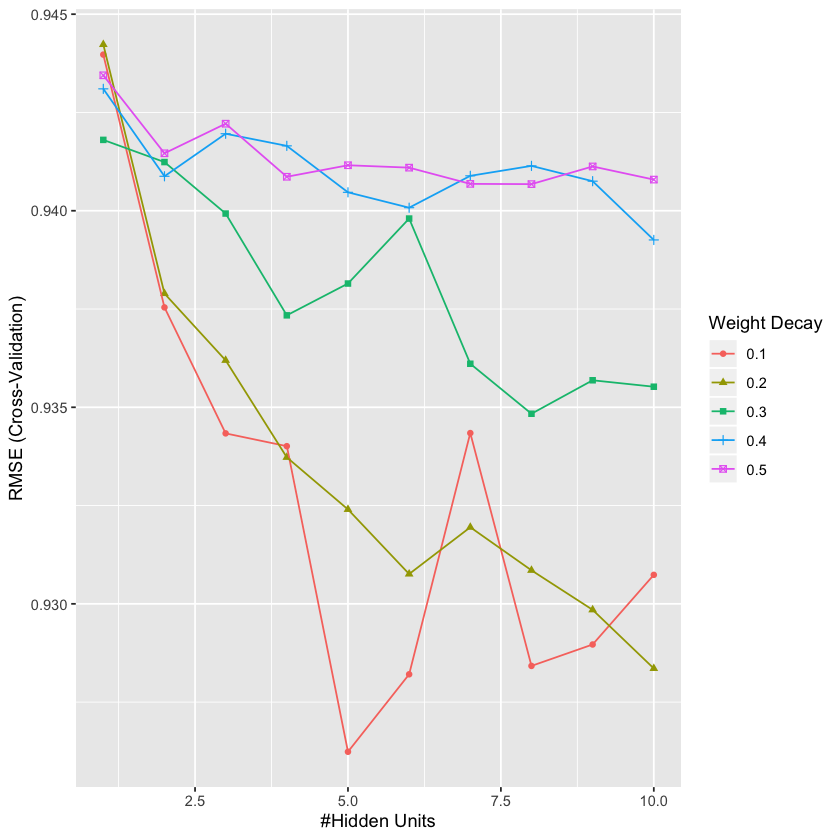

In [48]:
ggplot(nnetModel)

In [49]:
nnetModel$bestTune

,size,decay
,<dbl>,<dbl>
21,5,0.1


In [50]:
nnetModelStats <- evaluateStats(nnetModel)
nnetModelStats

$RMSE
[1] 0.758

$rSquare
[1] 0.246

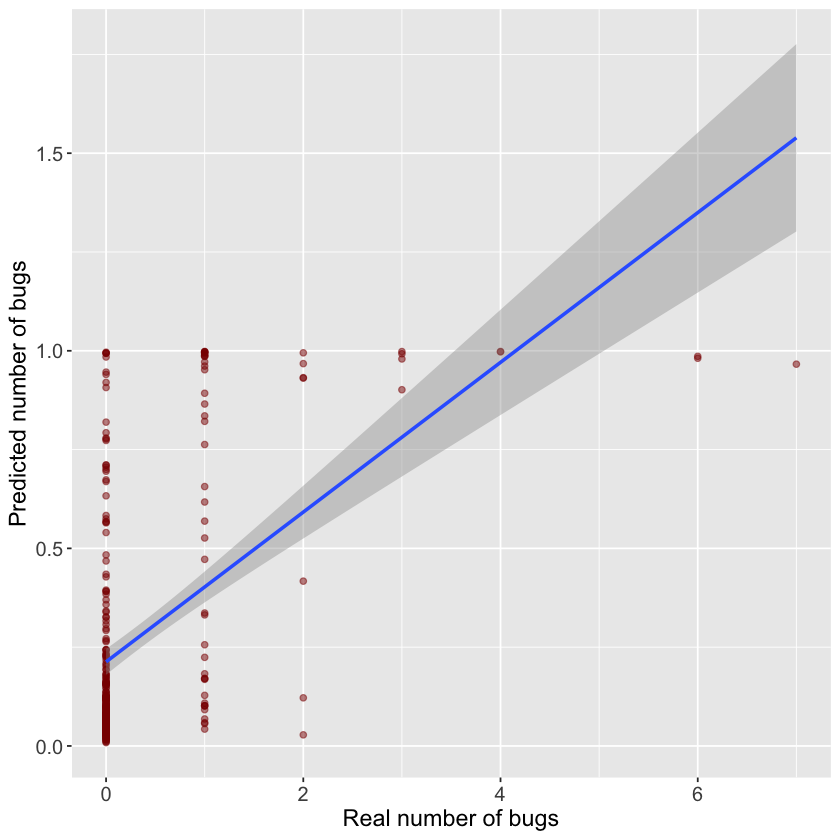

In [51]:
predictionChart(nnetModel)

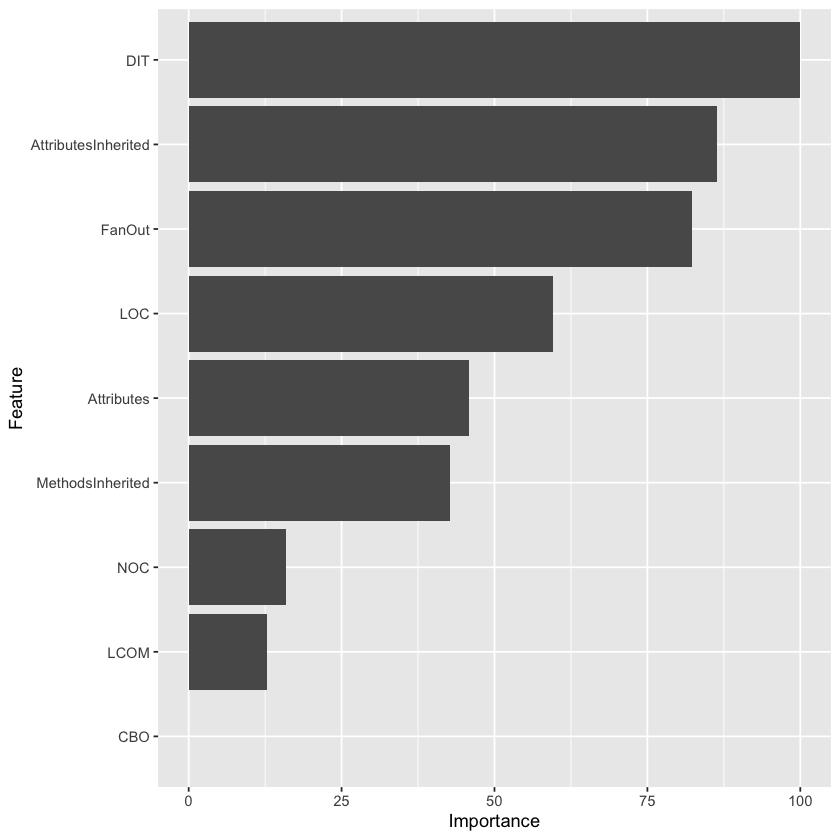

In [52]:
importancePlot(nnetModel)

# TODO Compare different regression models

In [53]:
compareDf <- data.frame(t(data.frame(
    knn = unlist(knnStats),
    knnPre = unlist(knnPreStats),
    rf = unlist(rfStats),
    xgb = unlist(xgbStats),
    xgbPre = unlist(xgbPreStats),
    nnetCaret = unlist(nnetModelStats)
)))
compareDf

,RMSE,rSquare
,<dbl>,<dbl>
knn,0.728,0.306
knnPre,0.752,0.258
rf,0.742,0.277
xgb,0.770,0.222
xgbPre,0.791,0.179
nnetCaret,0.758,0.246


To be continued...

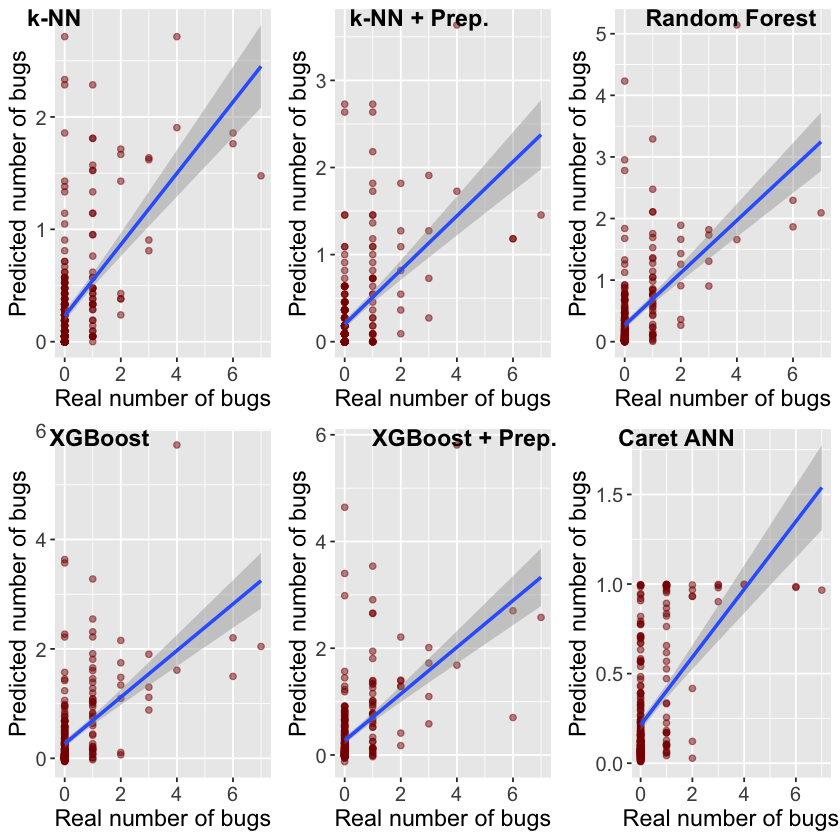

In [54]:
plot_grid(
    predictionChart(knnModel),
    predictionChart(knnPreModel),
    predictionChart(rfModel),
    predictionChart(xgbModel),
    predictionChart(xgbPreModel),
    predictionChart(nnetModel),
    
    labels = c('k-NN','k-NN + Prep.','Random Forest','XGBoost','XGBoost + Prep.','Caret ANN')
)

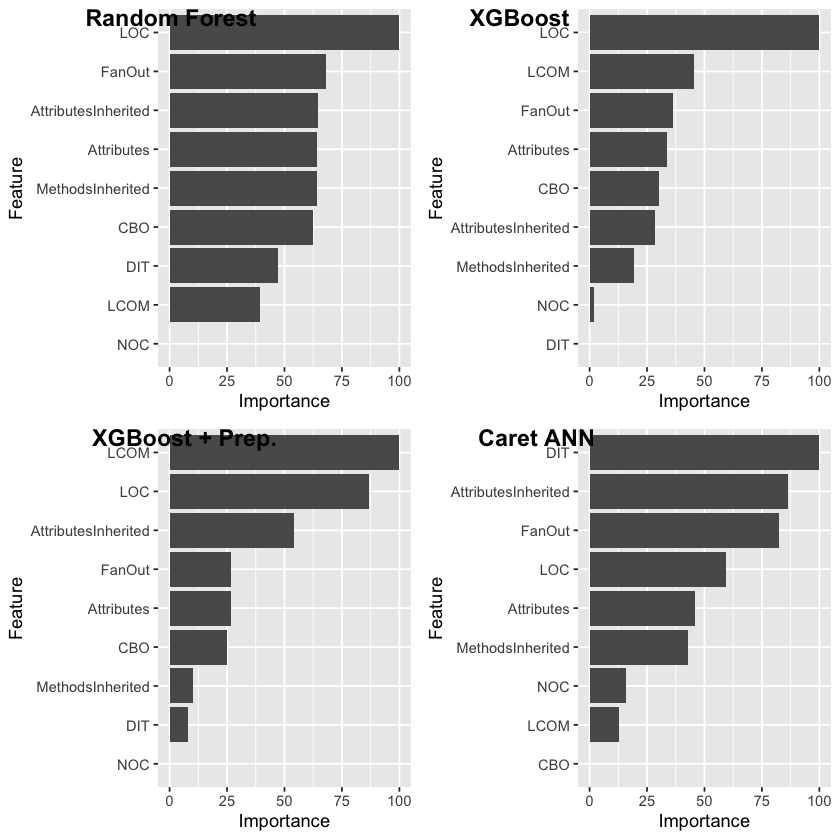

In [55]:
plot_grid(
    importancePlot(rfModel),
    importancePlot(xgbModel),
    importancePlot(xgbPreModel),
    importancePlot(nnetModel),
    
    labels = c('Random Forest','XGBoost','XGBoost + Prep.','Caret ANN')
)